# Visualize SEN12MS Data
---

Lucas Hu (lucashu@usc.edu), Fall 2019

1. Pick season
2. Pick scene
3. Pick patch
4. Visualize patch: RGB and Land Use

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sen12ms_dataLoader import SEN12MSDataset, Seasons, Sensor, S1Bands, S2Bands, LCBands

# setup data loader
sen12ms = SEN12MSDataset("/data/datasets/sen12ms")

In [2]:
# get scene IDs for seasons
SEASON = Seasons.SPRING
scene_ids = sen12ms.get_scene_ids(SEASON)
print(scene_ids)

{128, 1, 131, 132, 6, 134, 8, 9, 138, 140, 141, 142, 15, 143, 145, 146, 17, 148, 21, 144, 147, 24, 26, 31, 39, 40, 41, 44, 45, 53, 58, 63, 66, 71, 75, 77, 83, 97, 100, 101, 103, 106, 109, 110, 112, 113, 115, 117, 119, 120, 121, 122, 123, 124, 126, 127}


In [3]:
# get patch IDs for scene
SCENE_ID = 8
patch_ids = sen12ms.get_patch_ids(SEASON, SCENE_ID)
print(patch_ids)

[76, 574, 701, 72, 536, 655, 524, 216, 295, 488, 217, 333, 283, 777, 531, 542, 105, 836, 336, 654, 797, 325, 546, 779, 337, 608, 398, 404, 828, 802, 659, 636, 513, 364, 745, 671, 462, 424, 567, 533, 476, 788, 775, 83, 496, 572, 115, 278, 676, 561, 552, 365, 431, 695, 437, 55, 415, 239, 616, 637, 255, 161, 235, 449, 194, 33, 499, 686, 334, 344, 741, 133, 771, 697, 351, 228, 571, 760, 132, 495, 276, 485, 683, 419, 793, 64, 38, 595, 258, 556, 195, 323, 805, 681, 483, 422, 766, 320, 639, 460, 244, 826, 592, 441, 596, 555, 768, 70, 525, 750, 69, 56, 538, 589, 252, 717, 621, 200, 272, 136, 584, 93, 647, 213, 650, 648, 482, 786, 386, 672, 277, 30, 818, 150, 610, 366, 569, 230, 356, 630, 102, 626, 560, 371, 579, 245, 497, 809, 723, 226, 39, 707, 433, 611, 692, 166, 392, 831, 405, 469, 60, 214, 516, 421, 304, 428, 761, 155, 535, 587, 772, 635, 285, 628, 471, 515, 408, 339, 645, 588, 46, 85, 585, 110, 322, 675, 399, 156, 792, 292, 108, 578, 45, 470, 553, 75, 288, 354, 117, 127, 468, 135, 269, 90

In [4]:
PATCH_ID = 643

# get scene data
s1, s2, lc, bounds = sen12ms.get_triplets(SEASON, SCENE_ID, PATCH_ID, s2_bands=S2Bands.RGB, lc_bands=LCBands.landuse)

print("Season {}, Scene {}, Patch {}".format(SEASON, SCENE_ID, PATCH_ID))
print("Bounds: ", bounds[0])
print("s2.shape: ", s2.shape)
print("s2 range: {} to {}".format(np.min(s2[0]), np.max(s2[0])))
print("lc.shape: ", lc.shape)
print("land-use classes: ", np.unique(lc))
# TODO: get patch bounds/coords (rasterio)

# move bands to last axis
s2, lc = np.moveaxis(s2, 1, -1), np.moveaxis(lc, 1, -1)
s2, lc = np.squeeze(s2), np.squeeze(lc)

# normalize RGB bands
s2_normalized = s2 / np.max(s2)

Season Seasons.SPRING, Scene 8, Patch 643
Bounds:  {'bounds': BoundingBox(left=461012.8785067063, bottom=5230018.179322957, right=463572.8785067063, top=5232578.179322957), 'crs': CRS.from_epsg(32759), 'lnglat': (170.53685693834447, -43.07008574287624)}
s2.shape:  (1, 3, 256, 256)
s2 range: 206 to 2995
lc.shape:  (1, 1, 256, 256)
land-use classes:  [10 30]


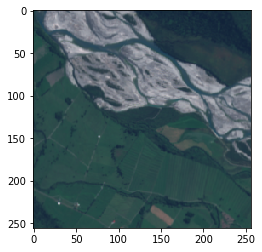

In [5]:
# visualize S2 RGB bands
plt.imshow(s2_normalized)
plt.show()

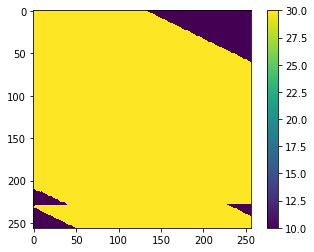

In [6]:
# visualize land use bands
# TODO: map LCCS values to actual class names
plt.imshow(lc)
plt.colorbar()
plt.show()

---

# Analyze ResNet Results

In [27]:
### RESULTS BY SEASON ###

import os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
results_dir = '/home/lucas/land-cover/results'

all_seasons = ['ROIs1158_spring', 'ROIs1868_summer', 'ROIs1970_fall', 'ROIs2017_winter']

# train_season --> test_season --> list of accuracies
train_season_to_test_season_results = defaultdict(lambda: defaultdict(list))

# iterate over all files in results_dir
for file in os.listdir(results_dir):
    if not file.endswith('.pkl'):
        continue
    # get pickled results
    with open(os.path.join(results_dir, file), 'rb') as f:
        results_by_season = pickle.load(f)
    # get train_season, train_scene from filename
    train_season = file.split('_scene')[0].split('sen12ms_')[1]
    train_scene = file.split('scene_')[-1].split('_model')[0]
    # store results in overall dict
    for test_season, test_results in results_by_season.items():
        for test_scene, (loss, acc) in test_results.items():
            train_season_to_test_season_results[train_season][test_season].append(acc)
            
# train_season --> test_season --> avg accuracy
avg_train_season_to_test_season_results = defaultdict(dict)
for train_season in train_season_to_test_season_results:
    for test_season, accs in train_season_to_test_season_results[train_season].items():
        avg_train_season_to_test_season_results[train_season][test_season] = np.mean(accs)
        
# get DF of results
results_df = pd.DataFrame(avg_train_season_to_test_season_results)
results_df = results_df.rename_axis("train_season", axis="index").rename_axis("test_season", axis="columns")
results_df = results_df.reindex(all_seasons, axis="index").reindex(all_seasons, axis="columns")
results_df.name = 'Cross-Season Classification Accuracy'
results_df

test_season,ROIs1158_spring,ROIs1868_summer,ROIs1970_fall,ROIs2017_winter
train_season,,,,
ROIs1158_spring,0.433116,0.351184,0.375062,0.312520
ROIs1868_summer,0.427343,0.380336,0.346006,0.314567
ROIs1970_fall,0.371396,0.329554,0.325929,0.349608
ROIs2017_winter,0.353987,0.302454,0.322965,0.354910


In [60]:
### RESULTS BY CONTINENT ###

import os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from sen12ms_dataLoader import SEN12MSDataset, Seasons, Sensor, S1Bands, S2Bands, LCBands
sen12ms = SEN12MSDataset("/data/datasets/sen12ms")
results_dir = '/home/lucas/land-cover/results'

# train_continent --> test_continent --> list of accuracies
train_continent_to_test_continent_results = defaultdict(lambda: defaultdict(list))

with open('./all_scene_locations.json', 'r') as f:
    all_scene_locations = json.load(f)

# iterate over all files in results_dir
for file in os.listdir(results_dir):
    if not file.endswith('.pkl'):
        continue
    # get pickled results
    with open(os.path.join(results_dir, file), 'rb') as f:
        results_by_season = pickle.load(f)
    # get train_season, train_scene from filename
    train_season = file.split('_scene')[0].split('sen12ms_')[1]
    train_scene = file.split('scene_')[-1].split('_model')[0]
    _, _, train_continent = all_scene_locations["{}_{}".format(train_season, train_scene)]
    # store results in overall dict
    for test_season, test_results in results_by_season.items():
        for test_scene, (loss, acc) in test_results.items():
            _, _, test_continent = all_scene_locations["{}_{}".format(test_season, test_scene)]
            train_continent_to_test_continent_results[train_continent][test_continent].append(acc)
            
# train_season --> test_season --> avg accuracy
avg_train_continent_to_test_continent_results = defaultdict(dict)
for train_continent in train_continent_to_test_continent_results:
    for test_continent, accs in train_continent_to_test_continent_results[train_continent].items():
        avg_train_continent_to_test_continent_results[train_continent][test_continent] = np.mean(accs)
        
# get DF of results
results_df = pd.DataFrame(avg_train_continent_to_test_continent_results)
results_df = results_df.rename_axis("train_continent", axis="index").rename_axis("test_continent", axis="columns")
results_df = results_df.sort_index(axis="index").sort_index(axis="columns")
results_df.name = 'Cross-Continent Classification Accuracy'
results_df

test_continent,Africa,Asia,Australia,Europe,North America,South America
train_continent,,,,,,
Africa,0.311520,0.286095,0.362724,0.405139,0.403539,0.321264
Asia,0.379193,0.389846,0.412002,0.443018,0.382855,0.374016
Australia,0.154990,0.320463,0.314495,0.334271,0.333670,0.307383
Europe,0.334917,0.335253,0.402099,0.428325,0.431343,0.367983
North America,0.134327,0.248237,0.277776,0.430693,0.460571,0.277673
South America,0.204190,0.293514,0.307259,0.408912,0.453284,0.371431
